Возьму **очищенный** [датасет из предыдущей ЛР](https://www.kaggle.com/datasets/padhmam/qs-world-university-rankings-2017-2022)

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve

%matplotlib inline 
sns.set(style="ticks")

# Открою датасет
data = pd.read_csv('../lab-2/university-rankings-cleared.csv', sep=",")
# характеристики
print("размер:", data.shape)
print("\nколонки:\n", data.dtypes)
data.head()
data.describe()

размер: (2820, 12)

колонки:
 university                 object
year                        int64
score                     float64
country                    object
city                       object
region                     object
type                       object
research_output            object
student_faculty_ratio     float64
international_students      int64
size                       object
faculty_count               int64
dtype: object


,year,score,student_faculty_ratio,international_students,faculty_count
count,2820.000000,2820.000000,2820.000000,2820.000000,2820.000000
mean,2019.640071,46.595532,10.652482,4483.347518,2561.719504
std,1.673794,18.813110,5.057507,4133.476621,1991.709499
min,2017.000000,23.500000,2.000000,5.000000,139.000000
25%,2018.000000,31.800000,7.000000,1747.000000,1218.000000
50%,2020.000000,40.600000,10.000000,3514.000000,2119.000000
75%,2021.000000,58.025000,13.000000,6062.000000,3354.000000
max,2022.000000,100.000000,44.000000,31049.000000,20311.000000


Разделю выборку. Целью исследования поставлю определение качества индивидуального отношения к студенту student_faculty_ratio (согласно авторам датасета, чем меньше число, тем обучение студента [более индивидуально](https://www.kaggle.com/code/padhmam?scriptVersionId=87338978&cellId=66])), от числа иностранных студентов, кол-ва персонала.

![](../lab-2/detaset_contents.png)

Оценю корреляцию данных и других числовых признаков:

C:\Users\dturc\AppData\Local\Temp\ipykernel_1900\3470817974.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(data.corr(), dtype=np.bool)


<AxesSubplot:>

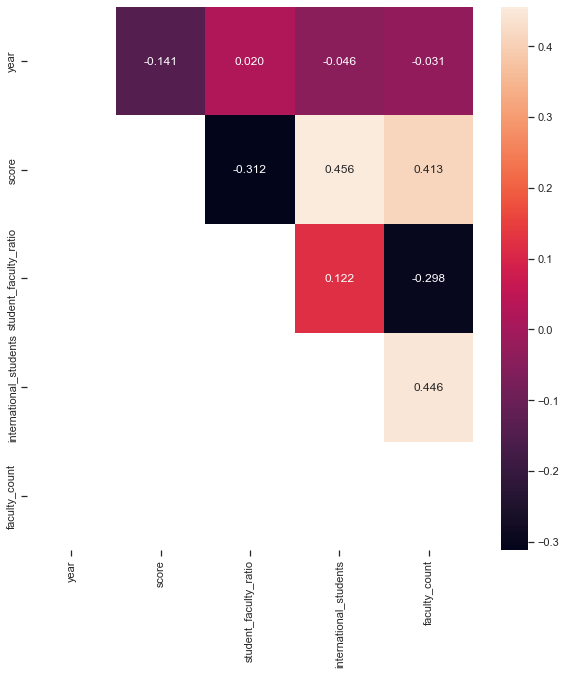

In [98]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,10))

# Треугольный вариант матрицы
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.tril_indices_from(mask)] = True
sns.heatmap(data.corr(), mask=mask, annot=True, fmt='.3f')

Видно, что для выбранной мной цели корреляция признаков довольно слабая.
По данному датасету намного лучше сделать исследование примерной оценки **score** от **international_students**, **faculty_count**, **student_faculty_ratio**.
Думаю, оценка так же зависит от страны и качества исследования, но они категориальные. Чтобы узнать корреляцию, придется перекодировать:

In [99]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

num_cols_list = []
cat_cols_list = []

for index, value in data.items():
  if (str(data[index].dtype) == "float64" or str(data[index].dtype) == "int64"):
    num_cols_list.append(index)
  elif str(data[index].dtype) == "object":
    cat_cols_list.append(index)

print(cat_cols_list)
print(num_cols_list)

['university', 'country', 'city', 'region', 'type', 'research_output', 'size']
['year', 'score', 'student_faculty_ratio', 'international_students', 'faculty_count']


university имеет data.shape[1] уникальных записей, т.е. брать его для обучения бессмысленно. Так же уберу из списка целевой признак и год, который имеет крайне слабую корреляцию 0.14 с целевым признаком

In [100]:
cat_cols_list.remove('university')
# cat_cols_list.remove('research_output')
num_cols_list.remove('score')
num_cols_list.remove('year')

In [101]:
# сохраню возможность декодирования сюда
cat_names_decoding_map = dict()

for cat in cat_cols_list:
  le = LabelEncoder()
  lables = le.fit_transform(data[cat])
  data[cat] = le.transform(data[cat])
  cat_names_decoding_map[cat] = {
    'encoder': le,
    'lables': lables,
  }

print(data.dtypes)

university                 object
year                        int64
score                     float64
country                     int32
city                        int32
region                      int32
type                        int32
research_output             int32
student_faculty_ratio     float64
international_students      int64
size                        int32
faculty_count               int64
dtype: object


Полезность признаков можно оценить, если построить модель решающее дерево: 

In [102]:
dtrr = DecisionTreeRegressor()
dtrr.fit(data[num_cols_list + cat_cols_list], data['score'])
for idx, cat in enumerate(num_cols_list + cat_cols_list):
  print(cat, '-', '{:1.2}'.format(dtrr.feature_importances_[idx]))


student_faculty_ratio - 0.26
international_students - 0.4
faculty_count - 0.098
country - 0.11
city - 0.07
region - 0.026
type - 0.0069
research_output - 0.018
size - 0.0075


Следует, как я и предположил изначально, взять признаки: **international_students**, **student_faculty_ratio**, **faculty_count**, но еще есть смысл добавить **city** и **country**. Единственное, ясно, что эти 2 признака коррелируют между собой, а ошибка в указании города вида "этого города нет в этой стране" только помешает предсказанию. Возьму только страну. 

In [103]:
cols_list = ['student_faculty_ratio', 'international_students', 'faculty_count', 'country']

X_train, X_test, Y_train, Y_test = train_test_split(data[cols_list], data['score'], test_size=0.2, random_state=1)
print('Размер тестовой выборки:', X_test.shape[0])
print('Размер тренировочной выборки:', X_train.shape[0])
print(X_train.head())
print()
print(Y_train.head())


Размер тестовой выборки: 564
Размер тренировочной выборки: 2256
      student_faculty_ratio  international_students  faculty_count  country
1216                    6.0                    1172           1733       60
2340                    7.0                    8311           2944       21
559                    15.0                    6979           3002       51
1223                   17.0                    1156           1700       60
2168                    7.0                     563           1608       40

1216    27.5
2340    86.3
559     52.9
1223    27.2
2168    30.5
Name: score, dtype: float64


Буду сравнивать 2 модели с K=5 и K=10

In [104]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, Y_train)
knn_reg_prediction = knn.predict(X_test)

In [105]:
knn2 = KNeighborsRegressor(n_neighbors=10)
knn2.fit(X_train, Y_train)
knn2_reg_prediction = knn2.predict(X_test)

### Метрики качества регрессии

   1. [Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) - средняя абсолютная ошибка

   1. [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) - средняя квадратичная ошибка, и [Root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) - корень из средней квадратичной ошибки
   
   1. Median absolute error
   
   1. [Метрика $R^2$ или коэффициент детерминации](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B4%D0%B5%D1%82%D0%B5%D1%80%D0%BC%D0%B8%D0%BD%D0%B0%D1%86%D0%B8%D0%B8) 
   

In [106]:
print(mean_absolute_error(Y_test, knn_reg_prediction))
print(mean_absolute_error(Y_test, knn2_reg_prediction))

4.736631205673759
9.056187943262412


Ошибка во втором случае хуже, значит, модель хуже. А что по среднеквадратичной ошибке?

In [107]:
print(mean_squared_error(Y_test, knn_reg_prediction))
print(mean_squared_error(Y_test, knn2_reg_prediction))

48.65829432624114
149.33449911347518


Квадрат ошибки тоже хуже во втором случае

Что с медианой?

In [108]:
print(median_absolute_error(Y_test, knn_reg_prediction))
print(median_absolute_error(Y_test, knn2_reg_prediction))

3.139999999999997
6.969999999999999


Снова хуже во втором случае

In [109]:
print(r2_score(Y_test, knn_reg_prediction))
print(r2_score(Y_test, knn2_reg_prediction))

0.8572150859469307
0.5617866611165513


чем ниже коэффициент детерминации ($R^2$), тем менее точна модель.

## Оптимизация гиперпараметра К

In [110]:
tuned_parameters = [{'n_neighbors': list(range(5, 35, 5))}]
tuned_parameters

[{'n_neighbors': [5, 10, 15, 20, 25, 30]}]

![](./metrics%20name%20list.png)

In [111]:
%%time
clf_rs = RandomizedSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
clf_rs.fit(X_train, Y_train)
print(clf_rs.best_params_, clf_rs.best_score_)
clf_rs.cv_results_['mean_test_score']

{'n_neighbors': 5} -86.90587904989896
CPU times: total: 172 ms
Wall time: 169 ms


c:\Users\dturc\source\repos\Denactive\TML\venv\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


array([ -86.90587905, -161.01266353, -179.6281489 , -190.92521516,
       -199.88355812, -209.57430155])

In [112]:
print(mean_squared_error(Y_train, knn.predict(X_train)))

21.602376418439718


Видимо, я угадал с гиперпараметром. В моем исследовании KNeighborsRegressor с n_neighbors=5 показал минимальную среднеквадратичную ошибку 48.65829432624114 на тестовых данных и 21.602376418439718 на тренировочных. Что-то не сходится, но RandomizedSearchCV не является надежным помошником на малом количестве фолдов, о чем и предупреждает надпись. Исследую окрестности более точным GridSearchCV'ом:

In [113]:
tuned_surroundings_5 = [{'n_neighbors': list(range(1, 10))}]
print(tuned_surroundings_5)

[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]}]


In [114]:
%%time
clf_gs = GridSearchCV(KNeighborsRegressor(), tuned_surroundings_5, cv=5, scoring='neg_mean_squared_error')
clf_gs.fit(X_train, Y_train)
clf_gs.best_params_
print(clf_gs.best_params_, clf_gs.best_score_)
print({1: clf_gs.cv_results_['mean_test_score'][1-1], 4: clf_gs.cv_results_['mean_test_score'][5-1]})

{'n_neighbors': 1} -20.321050428742424
{1: -20.321050428742424, 4: -86.90587904989896}
CPU times: total: 266 ms
Wall time: 242 ms


GridSearchCV дает более оптимальное значение для гиперпараметра - 1 вместо 5. Для 5 оценка совпадает с оценкой RandomSearch'а.

Проведу переобучение с гиперпараметром k = 1

In [115]:
knn_opt = KNeighborsRegressor(n_neighbors=1)
knn_opt.fit(X_train, Y_train)
knn_opt_prediction = knn_opt.predict(X_test)

In [116]:
print('\tK=1\t', '\tK=5\t')
print(mean_absolute_error(Y_test, knn_opt_prediction), '-', mean_absolute_error(Y_test, knn_reg_prediction))
print(mean_squared_error(Y_test, knn_opt_prediction), '-', mean_squared_error(Y_test, knn_reg_prediction))
print(median_absolute_error(Y_test, knn_opt_prediction), '-', median_absolute_error(Y_test, knn_reg_prediction))
print(r2_score(Y_test, knn_opt_prediction), '-', r2_score(Y_test, knn_reg_prediction))

	K=1	 	K=5	
2.857269503546099 - 4.736631205673759
16.425124113475178 - 48.65829432624114
2.0999999999999943 - 3.139999999999997
0.9518014355552787 - 0.8572150859469307


По всем критериям качество предсказания улучшилось

In [122]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\dturc\\source\\repos\\Denactive\\TML\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

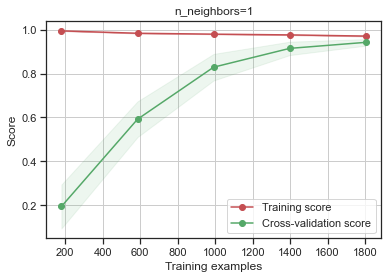

In [131]:
plot_learning_curve(KNeighborsRegressor(n_neighbors=1), 'n_neighbors=1', X_train, Y_train, cv=5)

In [119]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

TypeError: float() argument must be a string or a number, not 'dict'

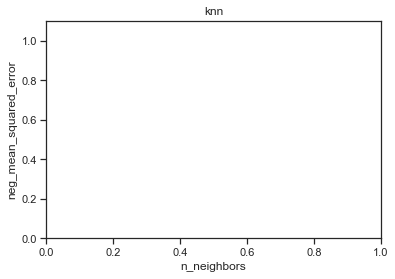

In [134]:
plot_validation_curve(KNeighborsRegressor(n_neighbors=1), 'knn', X_train, Y_train, 'n_neighbors', tuned_surroundings_5, 20, "neg_mean_squared_error")